## 1.构建网络，数字作者识别

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
%matplotlib inline

In [5]:
from tensorflow.python.client import device_lib

# 列出所有的本地机器设备
local_device_protos = device_lib.list_local_devices()
# 打印
#     print(local_device_protos)

# 只打印GPU设备
[print(x) for x in local_device_protos if x.device_type == 'GPU'],tf.test.is_gpu_available()

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3556048896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7890958390602145164
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"



([None], True)

In [3]:
all_date = np.load('x_train.npy').reshape(-1,28,28,1).astype('float32')/255
all_date.shape

(3000, 28, 28, 1)

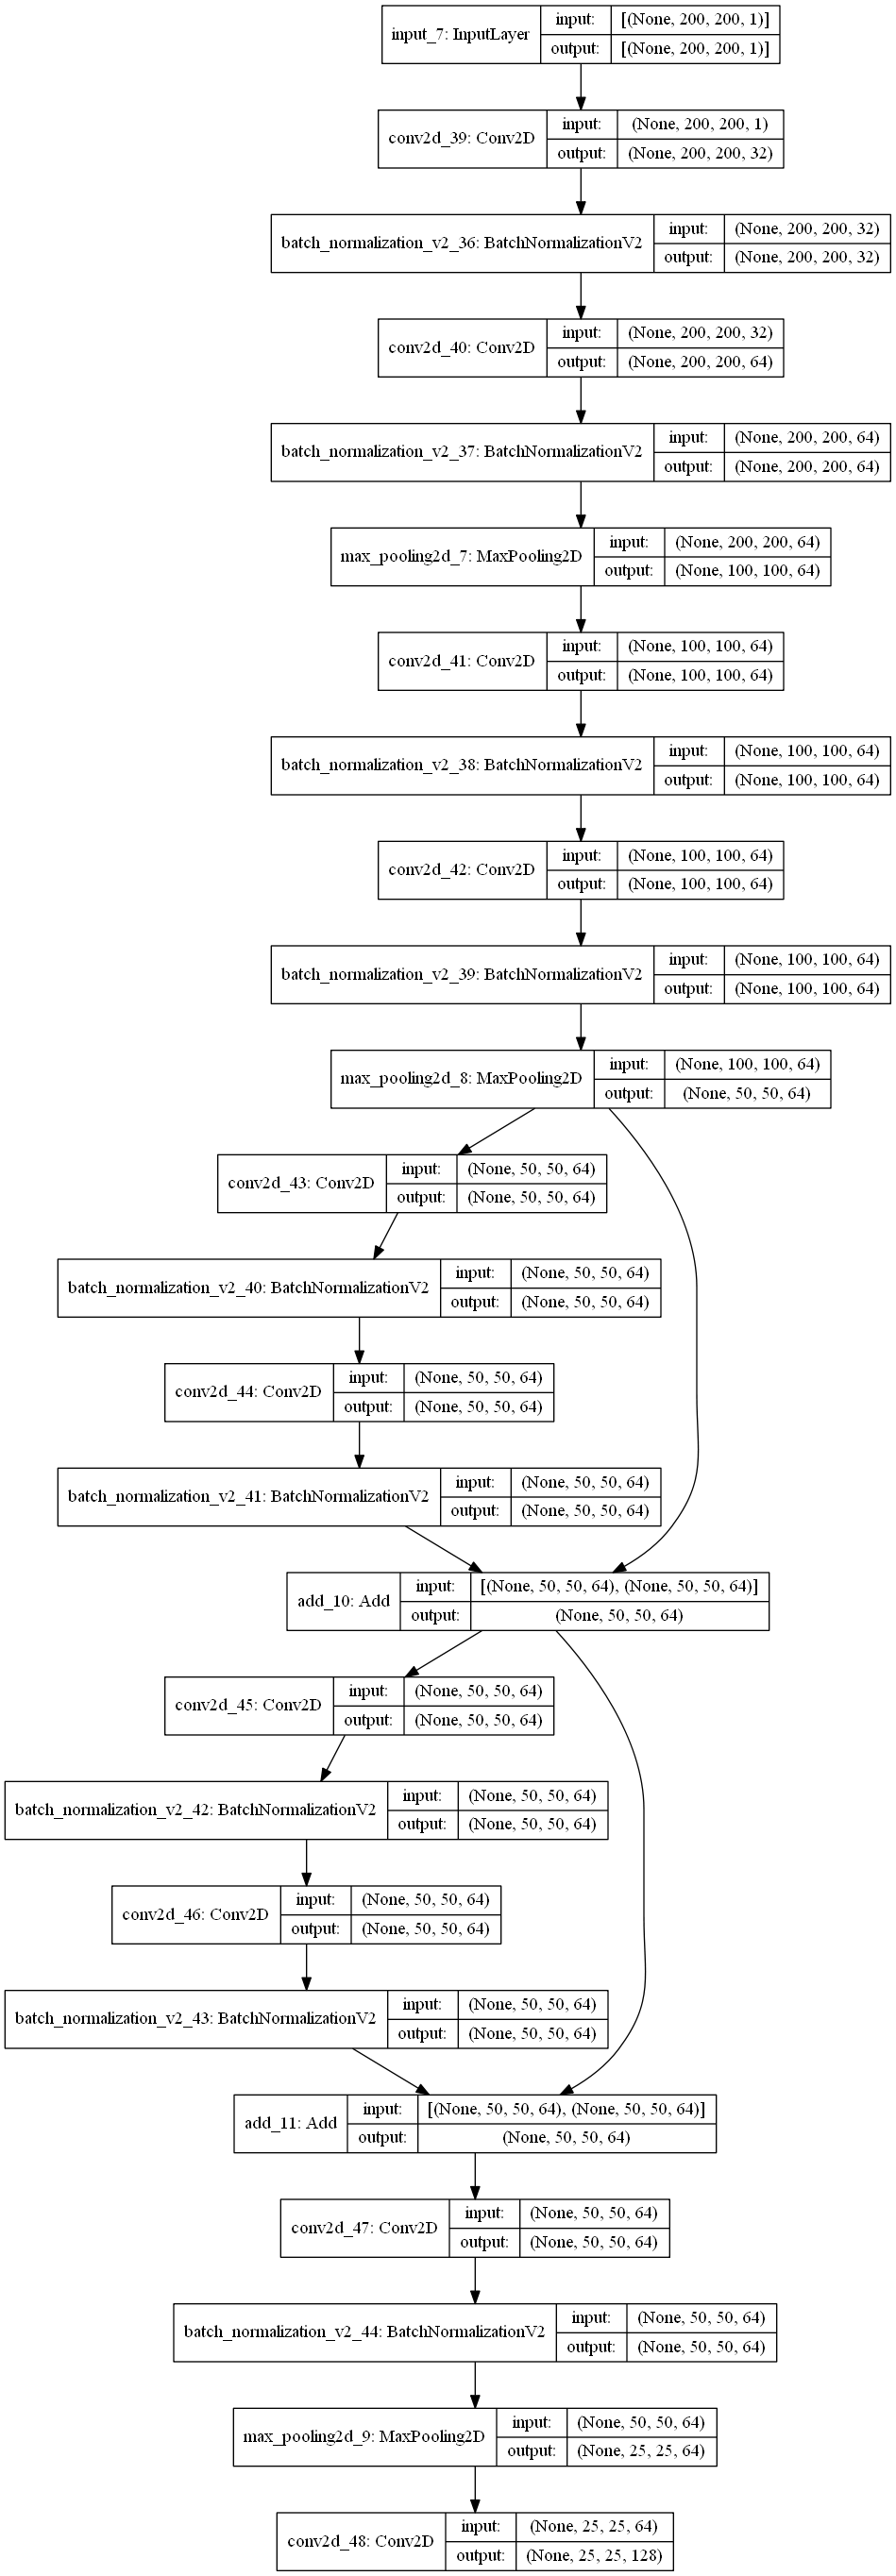

In [8]:
input_shape = (200, 200, 1)
img_input = keras.Input(shape=input_shape)
h0 = layers.Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(img_input)
h0 = layers.BatchNormalization()(h0)
h0 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h0)
h0 = layers.BatchNormalization()(h0)
block0_out = layers.MaxPooling2D(2)(h0)

h1 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(block0_out)
h1 = layers.BatchNormalization()(h1)
h1 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h1)
h1 = layers.BatchNormalization()(h1)
block1_out = layers.MaxPooling2D(2)(h1)
    
h2 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(block1_out)
h2 = layers.BatchNormalization()(h2)
h2 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h2)
h2 = layers.BatchNormalization()(h2)
block2_out = layers.add([h2, block1_out])

h3 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(block2_out)
h3 = layers.BatchNormalization()(h3)
h3 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h3)
h3 = layers.BatchNormalization()(h3)
block3_out = layers.add([h3, block2_out])

h4 = layers.Conv2D(128, 3, activation='relu',padding='same',kernel_initializer='glorot_normal')(block3_out)
h4 = layers.BatchNormalization()(h4)
h4 = layers.MaxPooling2D(2)(h4)
h4 = layers.Conv2D(128, 3, activation='relu',padding='same',kernel_initializer='glorot_normal')(h4)

model = keras.Model(img_input,h4)
keras.utils.plot_model(model, show_shapes=True)

((2835, 28, 28, 1),
 (150, 28, 28, 1),
 (150, 28, 28, 1),
 (2835,),
 (150,),
 (150,))

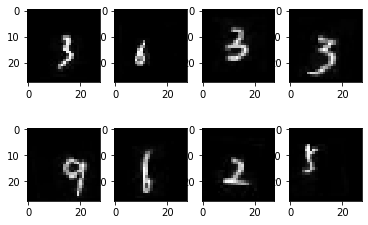

In [4]:
np.random.seed(9)
#np.random.randint(60,size=(5,30))
#(np.array([0,1,2]).reshape(1,-1)*np.ones((50,3))).reshape(5,30).astype('int32')
random_idx = ((np.asarray([i+j for i in range(0,600,150) for j in range(15)])[(np.array([8,9,10]).reshape(1,-1)*np.ones((50,3))).reshape(5,30).astype('int32')]+((np.arange(10)*15).reshape(-1,1)*np.ones(3)).reshape(1,-1))+((np.arange(5)*600).reshape(-1,1)*np.ones(30))).ravel().astype('int32')
con_idx = ((np.asarray([i+j for i in range(0,600,150) for j in range(15)])[(np.array([0,1,2]).reshape(1,-1)*np.ones((50,3))).reshape(5,30).astype('int32')]+((np.arange(10)*15).reshape(-1,1)*np.ones(3)).reshape(1,-1))+((np.arange(5)*600).reshape(-1,1)*np.ones(30))).ravel().astype('int32')

x_train = all_date[np.array([i for i in range(3000) if not i in np.concatenate((random_idx, con_idx))])].reshape(-1,28,28,1)
x_val = all_date[random_idx].reshape(-1,28,28,1)
x_test = all_date[con_idx].reshape(-1,28,28,1)

y_train = (np.arange(5).reshape(-1,1)*np.ones((5,540))).ravel().astype('uint8')
y_val = (np.arange(5).reshape(-1,1)*np.ones((5,30))).ravel().astype('uint8')
y_test = (np.arange(5).reshape(-1,1)*np.ones((5,30))).ravel().astype('uint8')

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(30)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(30)

#y_train = keras.utils.to_categorical(y_train, 10)
#y_test = keras.utils.to_categorical(y_test, 10)

indices = np.arange(x_train.shape[0]) 
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# 图像增强技术源码
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
     featurewise_center=True,
     featurewise_std_normalization=True,
     rotation_range=10,
     width_shift_range=0.1,
     height_shift_range=0.1,
     )

datagen.fit(x_train)

for i in range(135):
    data_iter = datagen.flow(x_train, y_train, batch_size=1)  
    x_train = np.concatenate((x_train, data_iter.next()[0]))
    y_train = np.concatenate((y_train, data_iter.next()[1]))
    
data_iter = datagen.flow(x_train, y_train, batch_size=8)
for i in range(8):
    plt.subplot(2,4,i+1)    
    plt.imshow(data_iter.next()[0][i].reshape(28,28), cmap='gray')

x_train.shape,x_test.shape,x_val.shape,y_train.shape,y_test.shape,y_val.shape

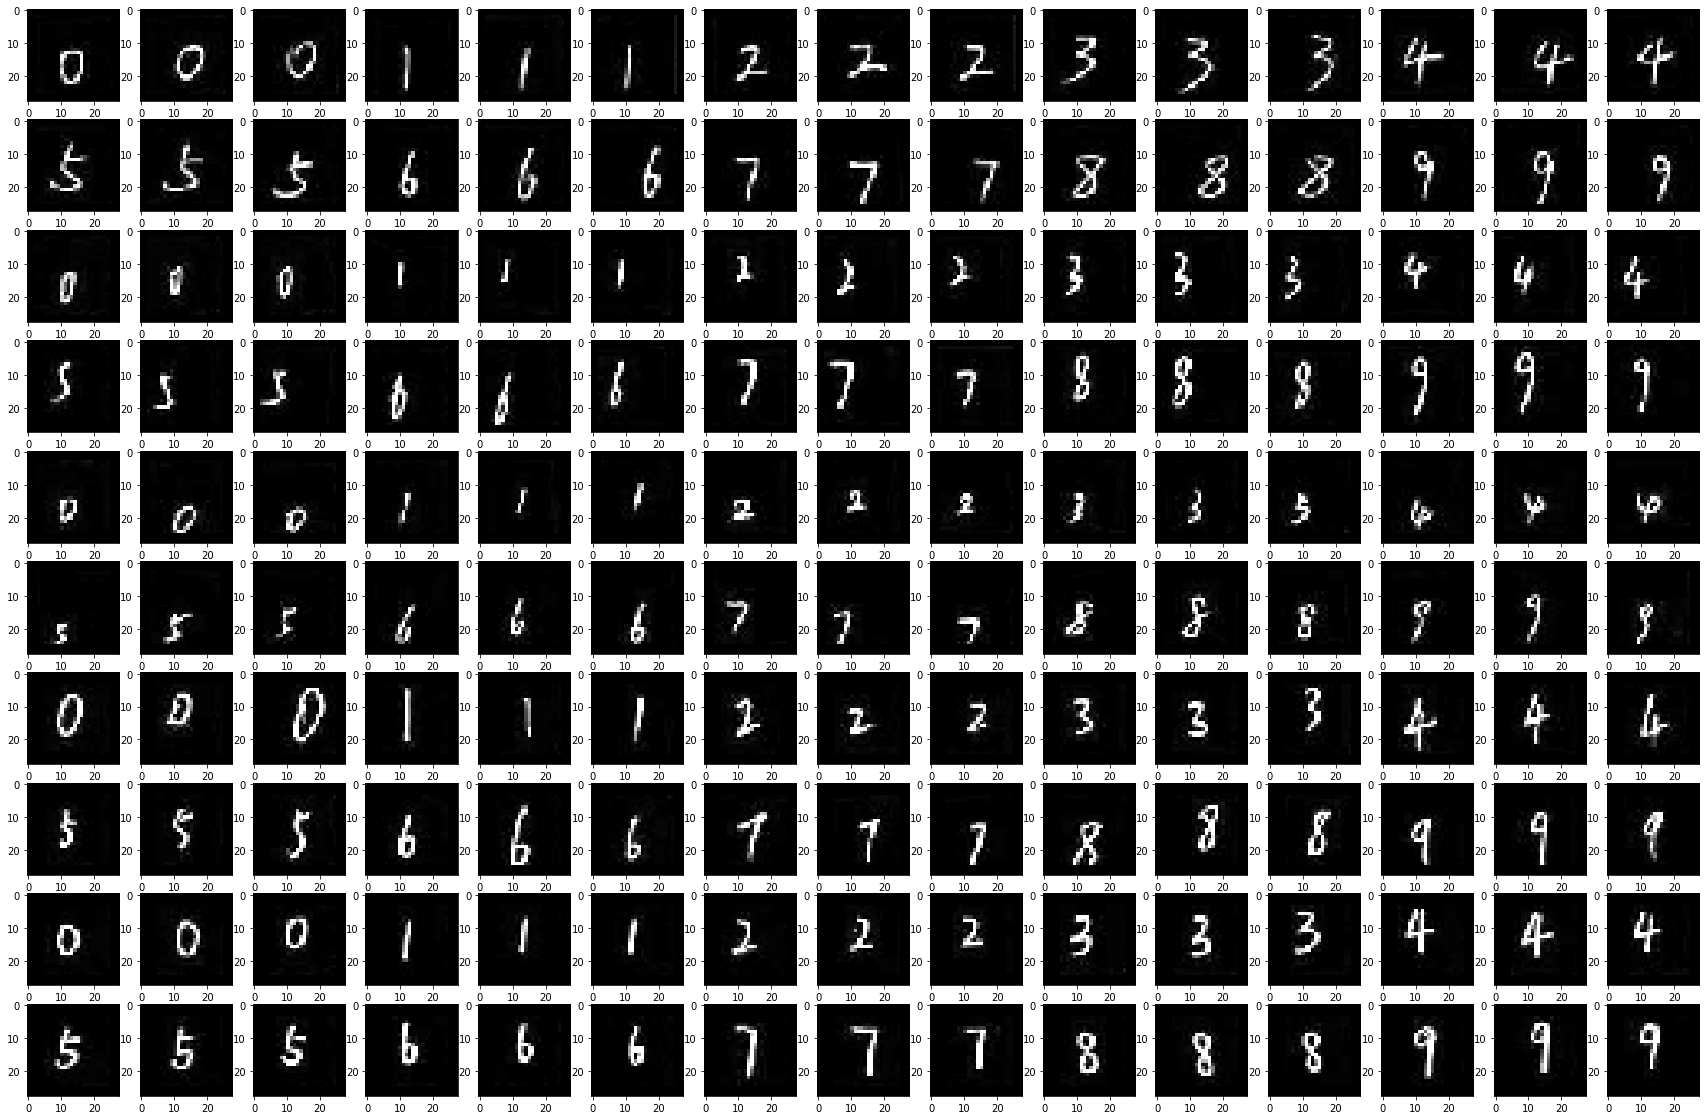

In [97]:
plt.figure(figsize=(2*15,2*10))
for i in range(x_test.shape[0]):
    plt.subplot(10,15,i+1)
    plt.imshow(x_val[i].reshape(28,28),cmap='gray')

## 导入原模型的参数

In [6]:
model_num = tf.keras.models.load_model('model_num.h5')
model_num = keras.Model(model_num.input, model_num.output, name = 'mnist_model')
model_num.trainable = False
model_min = keras.Model(model_num.layers[1].input, model_num.layers[4].output, name = 'min_model')
model_min.trainable = False

In [6]:
x_new = np.load('x_train.npy').reshape(-1,28,28,1).astype('float32')/255
y_new = np.load('y_train.npy').astype('uint8')
for i in range(10):    
    print('%d:'%(i),(np.argmax(model_num.predict(x_new[y_new==i,:,:].reshape(-1,28,28,1)),axis=1)==i).sum()/300)

0: 1.0
1: 0.9966666666666667
2: 0.9666666666666667
3: 0.9866666666666667
4: 0.9966666666666667
5: 0.97
6: 0.9966666666666667
7: 1.0
8: 0.9866666666666667
9: 0.9666666666666667


## 用之前的网络对比，但未迁移学习

In [10]:
try:
    del model_n
except:
    0
# LeNet
inputs_n = tf.keras.Input(shape=(28, 28, 1), name='img')
h1_n = layers.Conv2D(32, 5, activation='relu',padding='valid',kernel_initializer='glorot_normal')(inputs_n)
#h1_n = layers.BatchNormalization()(h1_n)
h1_n = layers.Dropout(0.5)(h1_n)
h1_n = layers.MaxPool2D(2)(h1_n)
h1_n = layers.Conv2D(64, 5, activation='relu',padding='valid',kernel_initializer='glorot_normal')(h1_n)
#h1_n = layers.BatchNormalization()(h1_n)
h1_n = layers.Dropout(0.5)(h1_n)

#h1_n = layers.MaxPool2D(2)(h1_n)
#h1_n = layers.Flatten()(h1_n)
#h2_n = layers.Dense(200,activation='relu')(h1_n)
#h2_n = layers.Dropout(0.5)(h2_n)
h2_n = layers.GlobalMaxPool2D()(h1_n)
#h2_n = layers.GlobalAvgPool2D()(h1_n)
outputs_n = layers.Dense(5, activation='softmax')(h2_n)

model_n = keras.Model(inputs=inputs_n, outputs=outputs_n, name='mnist_model')
model_n.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
             loss='sparse_categorical_crossentropy', # 直接填api，后面会报错
             metrics=['accuracy'])

history_n = model_n.fit(x_train, y_train,epochs=50, batch_size=30, validation_data=(x_val,y_val),)
test_scores = model_n.evaluate(x_test, y_test, verbose=0)
print('test loss:', test_scores[0])
print('test acc:', test_scores[1])
for i in range(5):    
    print('%d:'%(i),((np.argmax(model_n.predict(x_test[y_test==i,:,:].reshape(-1,28,28,1)),axis=1)-i)==0).sum()/30)

Train on 2835 samples, validate on 150 samples
Epoch 1/50
2835/2835 [==============================] - 1s 281us/sample - loss: 1.5934 - accuracy: 0.2938 - val_loss: 1.5762 - val_accuracy: 0.4800
Epoch 2/50
2835/2835 [==============================] - 1s 192us/sample - loss: 1.5274 - accuracy: 0.4056 - val_loss: 1.5559 - val_accuracy: 0.5133
Epoch 3/50
2835/2835 [==============================] - 0s 172us/sample - loss: 1.4845 - accuracy: 0.4843 - val_loss: 1.5391 - val_accuracy: 0.5733
Epoch 4/50
2835/2835 [==============================] - 0s 174us/sample - loss: 1.4407 - accuracy: 0.5411 - val_loss: 1.5138 - val_accuracy: 0.6200
Epoch 5/50
2835/2835 [==============================] - 0s 172us/sample - loss: 1.4134 - accuracy: 0.5471 - val_loss: 1.4925 - val_accuracy: 0.7000
Epoch 6/50
2835/2835 [==============================] - 0s 168us/sample - loss: 1.3737 - accuracy: 0.5848 - val_loss: 1.4732 - val_accuracy: 0.6333
Epoch 7/50
2835/2835 [==============================] - 1s 180us/

In [12]:
def plot_histroy(history):
    plt.figure(figsize=(18,6))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

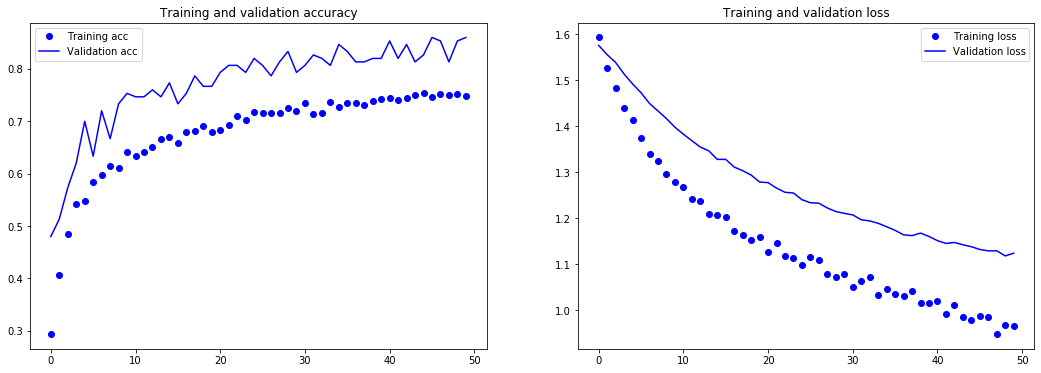

In [13]:
plot_histroy(history_n)

## 构建新的残差网络

In [41]:
try:
    del model 
except:
    0
inputs = keras.Input(shape=(28,28,1), name='img')

h0 = model_num(inputs)
h_temp = layers.Dense(1, activation='sigmoid')(h0)
h0 = layers.Dense(256,activation='tanh')(h0)
block0_out = layers.Dropout(0.5)(h0)
block0_out = layers.Multiply()([h_temp,block0_out])

h1 = layers.Conv2D(32, 3, activation='relu',kernel_initializer='glorot_normal')(inputs)
h1 = layers.BatchNormalization()(h1)
h1 = layers.Conv2D(64, 3, activation='relu',kernel_initializer='glorot_normal')(h1)
h1 = layers.BatchNormalization()(h1)
block1_out = layers.MaxPooling2D(3)(h1)

h_temp = model_min(inputs)

h2 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h_temp)
h2 = layers.BatchNormalization()(h2)
h2 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h2)
h2 = layers.BatchNormalization()(h2)
block2_out = layers.add([h2, h_temp])


h3 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(block2_out)
h3 = layers.BatchNormalization()(h3)
h3 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h3)
h3 = layers.BatchNormalization()(h3)
block3_out = layers.add([h3, block2_out])

h4 = layers.Conv2D(64, 3, activation='relu',kernel_initializer='glorot_normal')(block3_out)
h4 = layers.BatchNormalization()(h4)
h4 = layers.GlobalMaxPool2D()(h4)
#h4 = layers.Dense(256, activation='relu')(h4)
#h4 = layers.Dropout(0.5)(h4)

#h5 = layers.add([h4, block0_out])
#h5 = layers.Activation('relu')(h5)

outputs = layers.Dense(5, activation='softmax')(h4)

model = keras.Model(inputs, outputs, name='small resnet')
#model.summary() 
#keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)

## 模型开始训练，并运用回调函数

In [42]:
check_callback = [ 
#    keras.callbacks.ModelCheckpoint(filepath='mymodel_{epoch}.h5',save_best_only=True,monitor='val_loss', verbose=1),
    keras.callbacks.EarlyStopping( 
    monitor='val_loss',# Stop training when `val_loss` is no longer improving   
    min_delta=0.2,# "no longer improving" being defined as "no better than 1e-2 less" 
    patience=2,# "no longer improving" being further defined as "for at least 2 epochs" 
    
    verbose=1)]

initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.8,
    staircase=True
)
optimizer = keras.optimizers.RMSprop(lr=0.0001)
#callbacks=[check_callback],
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history_n = model.fit(x_train, y_train,epochs=40, batch_size=30, validation_data=(x_val,y_val),)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', test_scores[0])
print('test acc:', test_scores[1])
for i in range(5):    
    print('%d:'%(i),((np.argmax(model.predict(x_test[y_test==i,:,:].reshape(-1,28,28,1)),axis=1)-i)==0).sum()/30)

Train on 2835 samples, validate on 150 samples
Epoch 1/40
2835/2835 [==============================] - 2s 551us/sample - loss: 1.9140 - accuracy: 0.4688 - val_loss: 1.3579 - val_accuracy: 0.3733
Epoch 2/40
2835/2835 [==============================] - 1s 256us/sample - loss: 1.0062 - accuracy: 0.6649 - val_loss: 1.1628 - val_accuracy: 0.5200
Epoch 3/40
2835/2835 [==============================] - 1s 286us/sample - loss: 0.7583 - accuracy: 0.7372 - val_loss: 0.9918 - val_accuracy: 0.5733
Epoch 4/40
2835/2835 [==============================] - 1s 268us/sample - loss: 0.6559 - accuracy: 0.7700 - val_loss: 0.7874 - val_accuracy: 0.6867
Epoch 5/40
2835/2835 [==============================] - 1s 258us/sample - loss: 0.5359 - accuracy: 0.8095 - val_loss: 0.7017 - val_accuracy: 0.7733
Epoch 6/40
2835/2835 [==============================] - 1s 260us/sample - loss: 0.4975 - accuracy: 0.8215 - val_loss: 0.6740 - val_accuracy: 0.7933
Epoch 7/40
2835/2835 [==============================] - 1s 258us/

In [25]:
for i in range(5):    
    print('%d:'%(i),((np.argmax(model.predict(x_val[y_val==i,:,:].reshape(-1,28,28,1)),axis=1)-i)==0).sum()/30)

0: 0.8333333333333334
1: 0.9
2: 0.9333333333333333
3: 0.9666666666666667
4: 0.9


In [16]:
model_10 = tf.keras.models.load_model('model_per2.h5')
model_10.evaluate(x_test, y_test, verbose=0)

W0727 15:46:35.010795  1416 hdf5_format.py:261] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


[0.07780001937178894, 0.98]

In [47]:
model.evaluate(x_test, y_test, verbose=0)

[0.5649905011430383, 0.93333334]

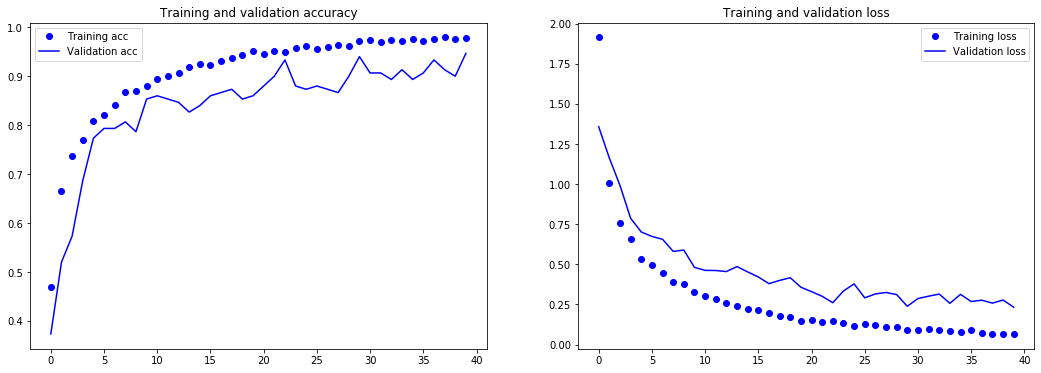

In [43]:
plot_histroy(history_n)

## 方法：
- 训练集：2700 + 数据增强 135 ~ 400 （根据网络复杂度选择不同）
- 验证集：150
- 测试集：150


1. 普通地使用几层卷积网络
2. 使用resnet，即简单残差网络
3. 将前几层换成已经训练好的卷积层
4. 使用前一个网络的输出作为输入


**经各种网络测试发现：数据过拟合趋势明显，训练精度0.97以上，测试或验证精度在0.9左右，训练损失也低于验证损失。做好各种过拟合技巧后发现，上述几种网络模型的测试集准确率差不多都在0.85左右（最高不过0.90），但在验证集上有的网络有0.93左右（最高出现过0.99），推测大家选的测试集不好识别，故自己选了验证集辅助判定网络性能。**


## 网络结构图分析

**小型残差网络**
![small_resnet_model0](fig/small_resnet_model0.png)

**自制双输入网络**
![model_per](fig/model_per.png)

## acc & loss 图分析

**学习率过大，波动太大**
![loss0](fig/loss_2/loss0.jpg)

![loss1](fig/loss_2/loss1.jpg)

---
---
**调整学习率，发现网络是过拟合**

![loss3](fig/loss_2/loss2.jpg)

![loss4](fig/loss_2/loss3.jpg)
*（未加BN层收敛较慢）*

---
---
**数据增强过多（700）**

![loss700](fig/loss_2/loss700.jpg)

---
---
**数据增强较少（100）**

![loss120](fig/loss_2/loss120.jpg)

---
---
**数据增强适中（135）**

![loss135](fig/loss_2/loss135.jpg)
![loss200](fig/loss_2/loss200.jpg)

---
---
**方法4，百次迭代**
![loss_double](fig/loss_2/loss_double.jpg)


# 问题提出

## 1.设置学习率过大使网络波动变大，但可以选择最好的一个模型?
可以但不稳定，尤其是对数据集相差较大的情况下

## 2.对于任何一个网络，是否都存在一种网络参数设置可以使得验证损失（精度）接近训练损失（精度）？
可以

# 分割线

---
---
# 2.迁移学习

In [21]:
model3.summary()

Model: "min_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
min_model (Model)            (None, 8, 8, 64)          52096     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 20485     
Total params: 72,581
Trainable params: 72,581
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_num = tf.keras.models.load_model('model_num.h5')
model_num = keras.Model(model_num.input, model_num.output, name = 'mnist_model')
inputs = keras.Input(shape=(28,28,1), name='img')
model3 = keras.Model(model_num.layers[1].input, model_num.layers[-3].output, name = 'min_model')
#model3.trainable = False
h = model3(inputs)
#h = layers.MaxPool2D(2)(h)
# valid
#h = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='glorot_normal')(h)
#h = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='glorot_normal')(h)
h = layers.Flatten()(h)
#h = layers.Dense(256,activation='relu')(h)
#h = layers.Dropout(0.5)(h)
outputs = layers.Dense(5,activation='softmax')(h)
model3 = keras.Model(inputs, outputs, name = 'min_model')
model3.compile(optimizer=keras.optimizers.RMSprop(lr=0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
history3 = model3.fit(x_train, y_train,epochs=40, batch_size=30, validation_data=(x_val,y_val),)
test_scores = model3.evaluate(x_test, y_test, verbose=0)
print('test loss:', test_scores[0])
print('test acc:', test_scores[1])
K.clear_session()

Train on 2835 samples, validate on 150 samples
Epoch 1/40
2835/2835 [==============================] - 1s 276us/sample - loss: 0.6211 - accuracy: 0.7862 - val_loss: 0.3156 - val_accuracy: 0.9467
Epoch 2/40
2835/2835 [==============================] - 1s 189us/sample - loss: 0.2984 - accuracy: 0.8970 - val_loss: 0.2143 - val_accuracy: 0.9600
Epoch 3/40
2835/2835 [==============================] - 0s 176us/sample - loss: 0.2248 - accuracy: 0.9206 - val_loss: 0.1787 - val_accuracy: 0.9533
Epoch 4/40
2835/2835 [==============================] - 1s 180us/sample - loss: 0.1699 - accuracy: 0.9439 - val_loss: 0.1321 - val_accuracy: 0.9733
Epoch 5/40
2835/2835 [==============================] - 1s 190us/sample - loss: 0.1564 - accuracy: 0.9439 - val_loss: 0.1355 - val_accuracy: 0.9667
Epoch 6/40
2835/2835 [==============================] - 0s 171us/sample - loss: 0.1325 - accuracy: 0.9520 - val_loss: 0.1101 - val_accuracy: 0.9800
Epoch 7/40
2835/2835 [==============================] - 0s 174us/

In [67]:
# 用回调函数再训练一次，保留做好的模型
check_callback = [ 
    keras.callbacks.ModelCheckpoint(filepath='mymodel_{epoch}.h5',monitor='val_loss', verbose=1),
 ]
model3.fit(x_train, y_train,epochs=40, batch_size=30, validation_data=(x_val,y_val),callbacks = check_callback)

Train on 2835 samples, validate on 150 samples
Epoch 1/40
2730/2835 [===========================>..] - ETA: 0s - loss: 0.0835 - accuracy: 0.9762
Epoch 00001: saving model to mymodel_1.h5
2835/2835 [==============================] - 1s 278us/sample - loss: 0.0847 - accuracy: 0.9760 - val_loss: 0.0606 - val_accuracy: 0.9733
Epoch 2/40
2550/2835 [=========================>....] - ETA: 0s - loss: 0.0886 - accuracy: 0.9804
Epoch 00002: saving model to mymodel_2.h5
2835/2835 [==============================] - 1s 178us/sample - loss: 0.0878 - accuracy: 0.9802 - val_loss: 0.0493 - val_accuracy: 0.9733
Epoch 3/40
2580/2835 [==========================>...] - ETA: 0s - loss: 0.1089 - accuracy: 0.9775
Epoch 00003: saving model to mymodel_3.h5
2835/2835 [==============================] - 1s 178us/sample - loss: 0.1142 - accuracy: 0.9760 - val_loss: 0.0698 - val_accuracy: 0.9733
Epoch 4/40
2730/2835 [===========================>..] - ETA: 0s - loss: 0.0941 - accuracy: 0.9791
Epoch 00004: saving mode

In [18]:
model = tf.keras.models.load_model('model_re0.h5')
model.evaluate(x_val,y_val,verbose=0)

[0.07960905611515046, 1.0]

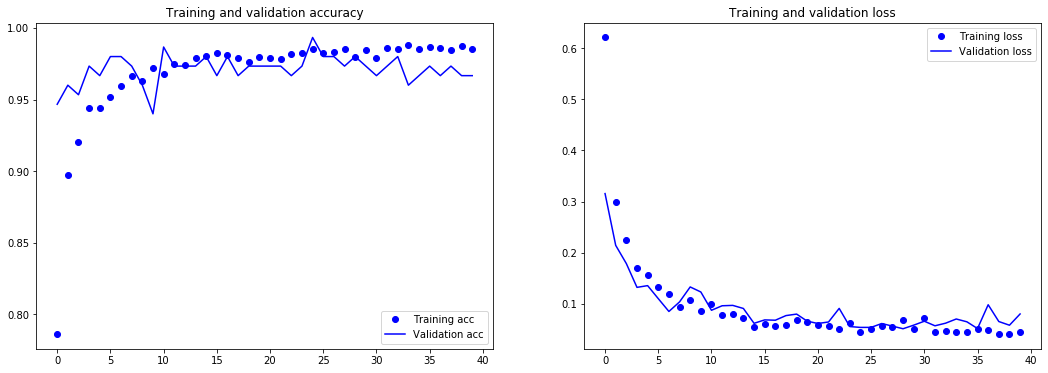

In [31]:
plot_histroy(history3)

*本次迁移学习成果以ppt形式展示*